In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from models.enums.chartType import TrainingCharts
from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil

In [8]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [9]:
# The dataset for the previous results
# import numpy as np
# from functools import reduce
# import torch
# def xor(x):
#     return reduce(lambda a, b: a ^ b, x)

# batch_size = 200
# in_features = 2
# X = np.random.randint(0, 2, size=(batch_size, in_features))
# y = np.array([xor(x) for x in X])

# X = torch.tensor(X).float()
# y = torch.tensor(y).long()
# trainUtil = TrainUtil(X, y, split = 100)

In [11]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [7]:
layers_6 = 6
model_params_all_6 = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10), "l4": (200, 15), "l5": (250, 20), "l6": (200, 10)}
model_params_first_6 = {"l1": (200, 15), "l2": (250, None), "l3": (200, None), "l4": (200, None), "l5": (250, None), "l6": (200, None)}
model_params_second_6 = {"l1": (200, None), "l2": (250, 20), "l3": (200, None), "l4": (200, None), "l5": (250, None), "l6": (200, None)}
model_params_third_6 = {"l1": (200, None), "l2": (250, None), "l3": (200, 10), "l4": (200, None), "l5": (250, None), "l6": (200, None)}
model_params_fourth_6 = {"l1": (200, None), "l2": (250, None), "l3": (200, None), "l4": (200, 15), "l5": (250, None), "l6": (200, None)}
model_params_fifth_6 = {"l1": (200, None), "l2": (250, None), "l3": (200, None), "l4": (200, None), "l5": (250, 20), "l6": (200, None)}
model_params_sizth_6 = {"l1": (200, None), "l2": (250, None), "l3": (200, None), "l4": (200, None), "l5": (250, None), "l6": (200, 10)}
model_params_first_and_second_6 = {"l1": (200, 15), "l2": (250, 20), "l3": (200, None), "l4": (200, None), "l5": (250, None), "l6": (200, None)}
model_params_first_second_third_6 = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 15), "l4": (200, None), "l5": (250, None), "l6": (200, None)}
model_params_first_second_third_fourth_6 = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 15), "l4": (200, 15), "l5": (250, None), "l6": (200, None)}
model_params_first_second_third_fourth_fifth_6 = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 15), "l4": (200, 15), "l5": (250, 20), "l6": (200, None)}

In [9]:
def get_models_to_plot_from_combined(combined_charts):
    ortho_models = [ i  for i in combined_charts.get_models() if "Ortho" in i]
    sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i and "Ortho" not in i]
    control_models = [ i for i in combined_charts.get_models() if "Control" in i]
    dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]

    return ortho_models, sparse_models, control_models, dense_models

In [11]:
model_types_6 = {"Complete Sparse model": model_params_all_6, 
               "1st L Sparse": model_params_first_6, 
               "2nd L Sparse": model_params_second_6,
               "3rd L Sparse": model_params_third_6,
               "4th L Sparsee": model_params_fourth_6,
               "5th L Sparse": model_params_fifth_6,
               "6th L Sparse": model_params_sizth_6,
               "1st and 2nd Sparse": model_params_first_and_second_6,
               "1st, 2nd and 3rd Sparse": model_params_first_second_third_6,
               "1, 2, 3, 4 Sparse": model_params_first_second_third_fourth_6,
               "1, 2, 3, 4, 5 Sparse": model_params_first_second_third_fourth_fifth_6,
            }
chartUtils_6 = {}
chartUtils_6["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers_6,  
    model_params = model_types_6["Complete Sparse model"],
    # n_epochs=100,
)

for modelName in model_types_6:
    chartUtils_6[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers_6, 
        model_params = model_types_6[modelName],
        # n_epochs = 100
        )

In [12]:
model_keys = list(chartUtils_6.keys())
combined_charts: ChartUtil = chartUtils_6[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_6[key])

ortho_models = [ i  for i in combined_charts.get_models() if "Ortho" in i]
sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i and "Ortho" not in i]
control_models = [ i for i in combined_charts.get_models() if "Control" in i]
dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42332/2943927228.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for( no_std = True, set_unique_colors= True).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42332/2943927228.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for( no_std = True, value_to_plot = TrainingCharts.ACC, set_unique_colors= True).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42332/2943927228.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_test_accu_for_models(width_alpha=3).show()


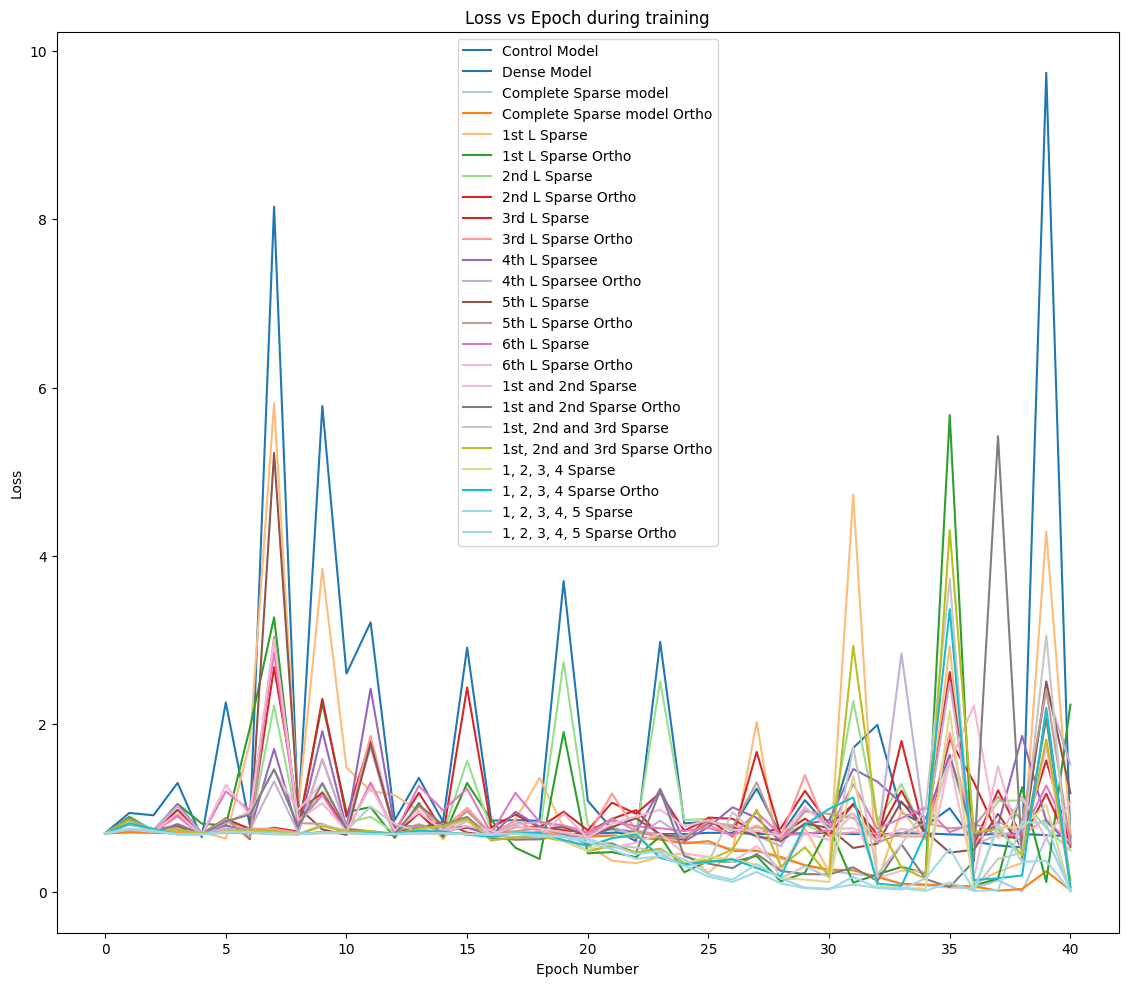

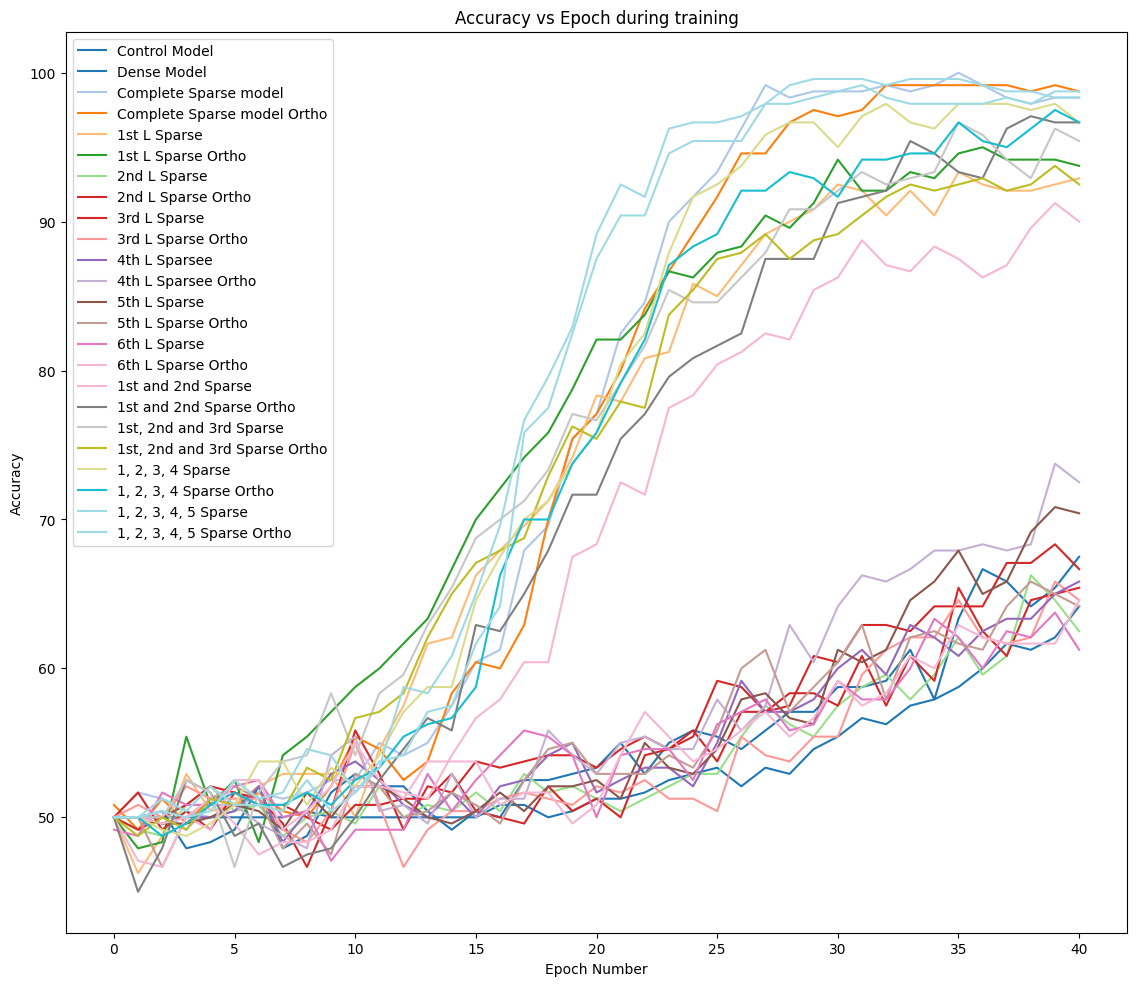

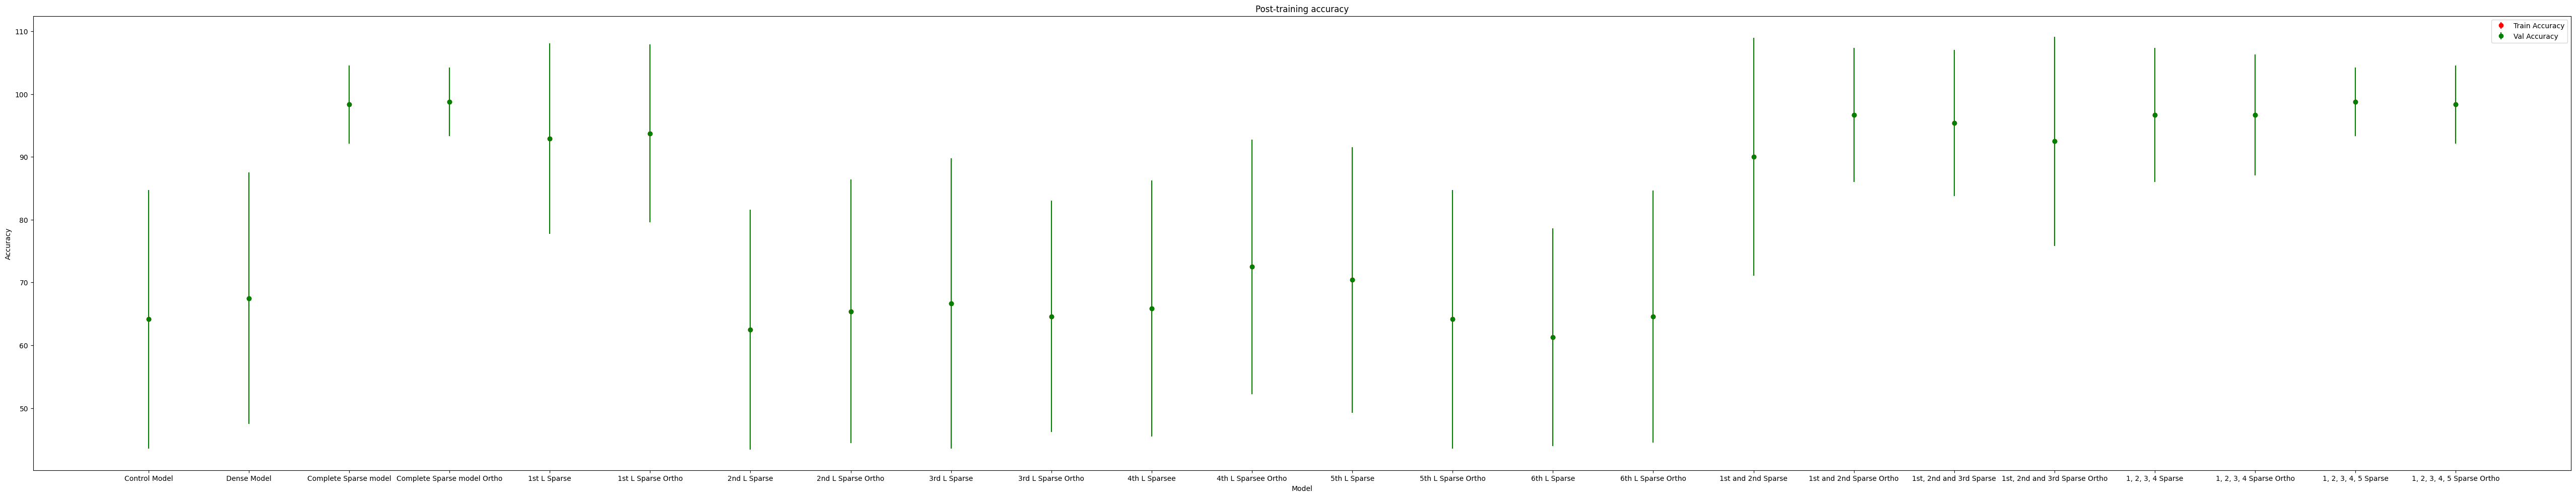

In [13]:
combined_charts.plot_training_data_for( no_std = True, set_unique_colors= True).show()
combined_charts.plot_training_data_for( no_std = True, value_to_plot = TrainingCharts.ACC, set_unique_colors= True).show()
combined_charts.plot_test_accu_for_models(width_alpha=3).show()

In [ ]:
layers = 3
model_params_all = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10)}
model_params_first = {"l1": (200, 15), "l2": (250, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (250, 20), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (250, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 15), "l2": (250, 20), "l3": (200, None)}
model_params_first_third = {"l1": (200, 15), "l2": (250, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (250, 20), "l3": (200, 10)}

In [ ]:
model_types = {
        "Complete Sparse model": model_params_all, 
        "1st L Sparse": model_params_first, 
        "2nd L Sparse": model_params_second,
        "3rd L Sparse": model_params_third,
        "1st and 2nd L Sparse": model_params_first_second,
        "1st and 3rd L Sparse": model_params_first_third,
        "2nd and 3rd L Sparse": model_params_second_third
    }
chartUtils = {}
chartUtils["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,
    model_params = model_types["Complete Sparse model"],
    n_epochs=150,
    # batch_train= True
)

for modelName in model_types:
    chartUtils[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 150,
        # batch_train= True
        )

In [12]:
model_keys = list(chartUtils.keys())
combined_charts: ChartUtil = chartUtils[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils[key])

ortho_models = [ i  for i in combined_charts.get_models() if "Ortho" in i]
sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i and "Ortho" not in i]
control_models = [ i for i in combined_charts.get_models() if "Control" in i]
dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_85169/3009354890.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_85169/3009354890.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_85169/3009354890.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_85169/3009354890.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


Title to plot is val acc


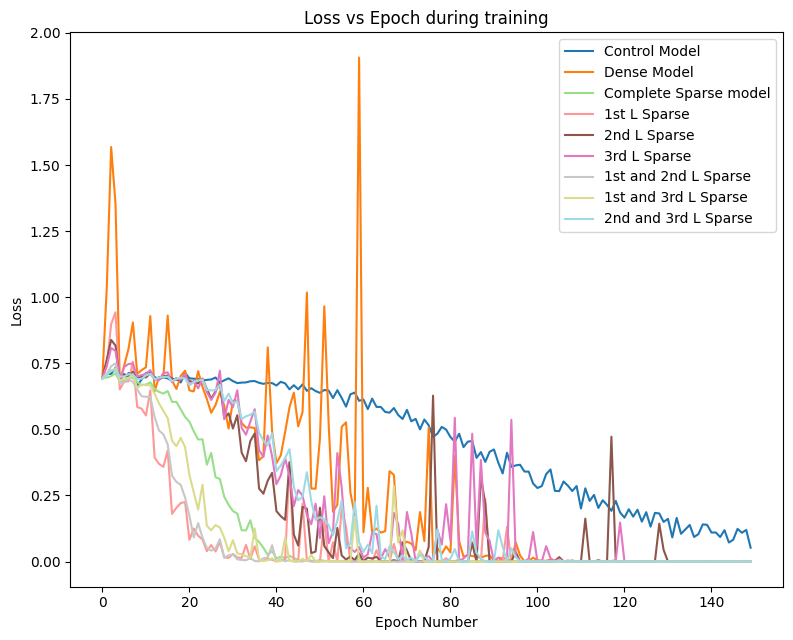

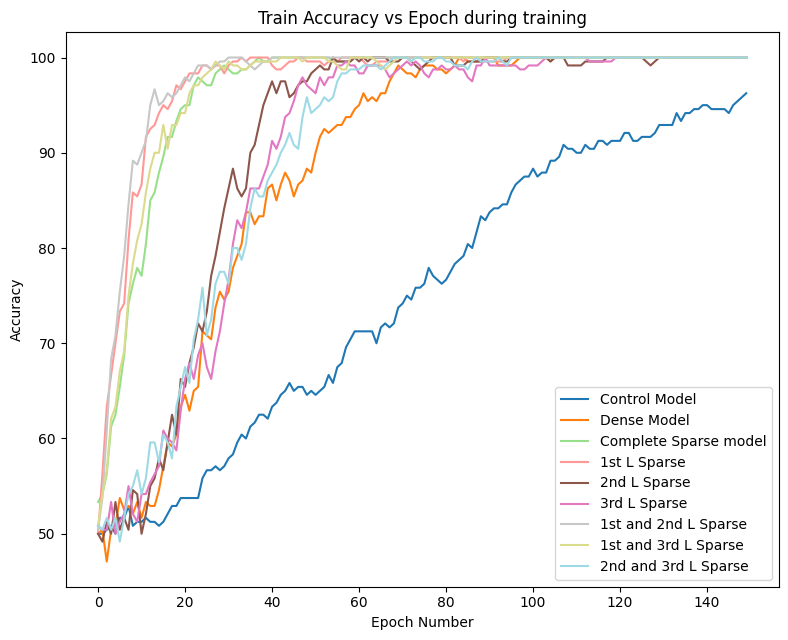

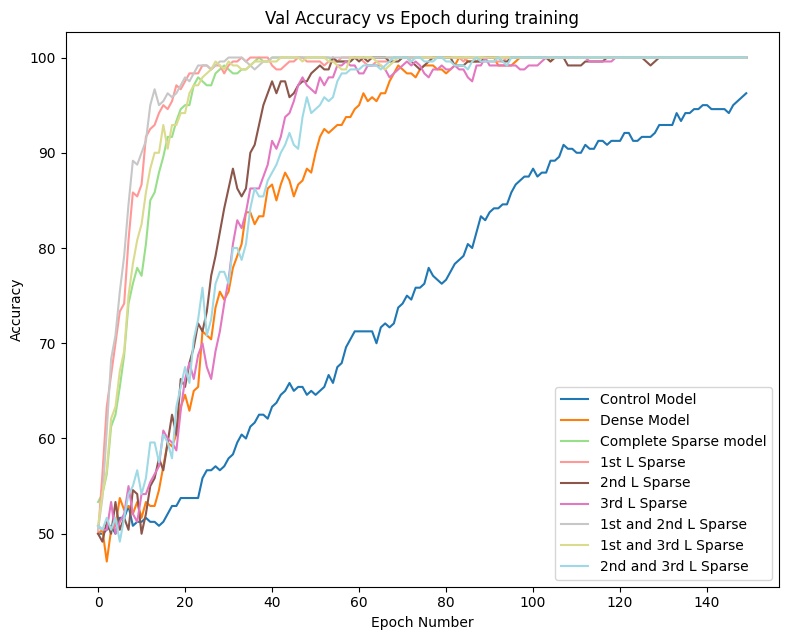

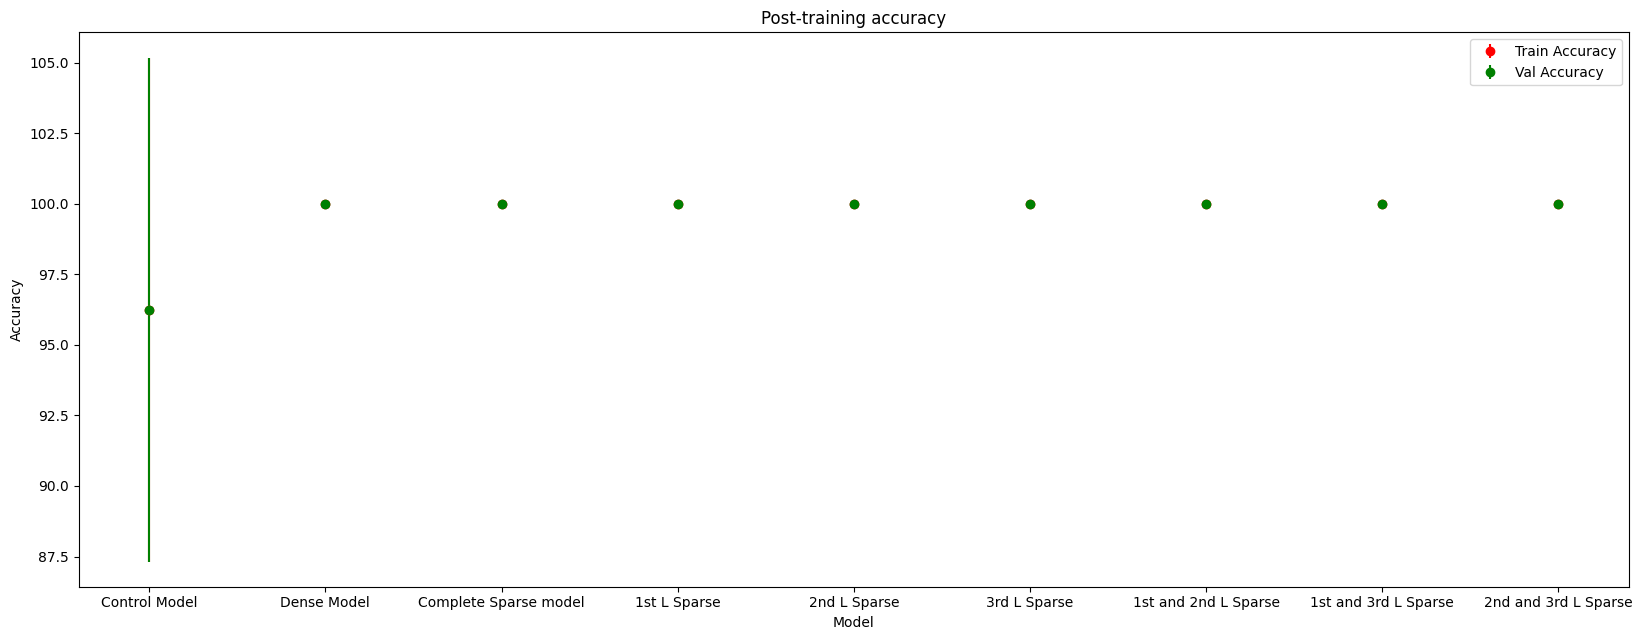

In [ ]:
combined_charts.plot_training_data_for(no_std = True,
                                    #   models = sparse_models + ortho_models 
                                       ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    # models = sparse_models + ortho_models
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    # models = sparse_models + ortho_models
    ).show()

In [56]:
layers = 2
model_params_all = {"l1": (200, 15), "l2": (250, 20)}
model_params_first = {"l1": (200, 15), "l2": (250, None)}
model_params_second = {"l1": (200, None), "l2": (250, 20)}

In [76]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second
            }
chartUtils = {}
chartUtils["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=60,
    # batch_train= True
)

for modelName in model_types:
    chartUtils[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 60,
        # batch_train= True
        )

In [77]:
model_keys = list(chartUtils.keys())
combined_charts: ChartUtil = chartUtils[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils[key])

ortho_models = [ i  for i in combined_charts.get_models() if "Ortho" in i]
sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i and "Ortho" not in i]
control_models = [ i for i in combined_charts.get_models() if "Control" in i]
dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_19480/403261378.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_19480/403261378.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_19480/403261378.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


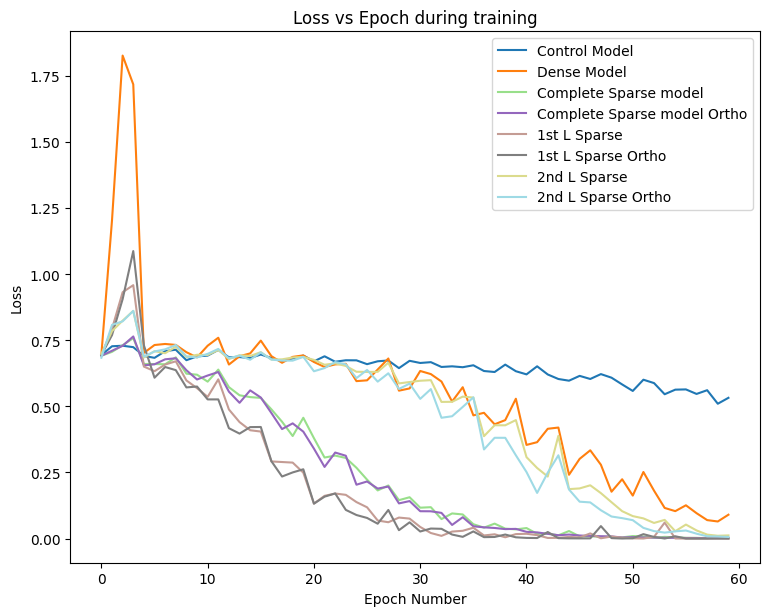

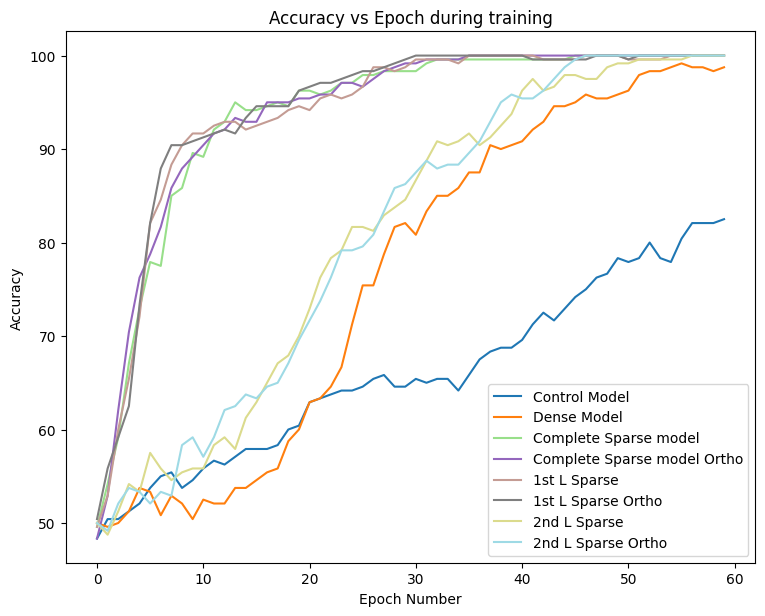

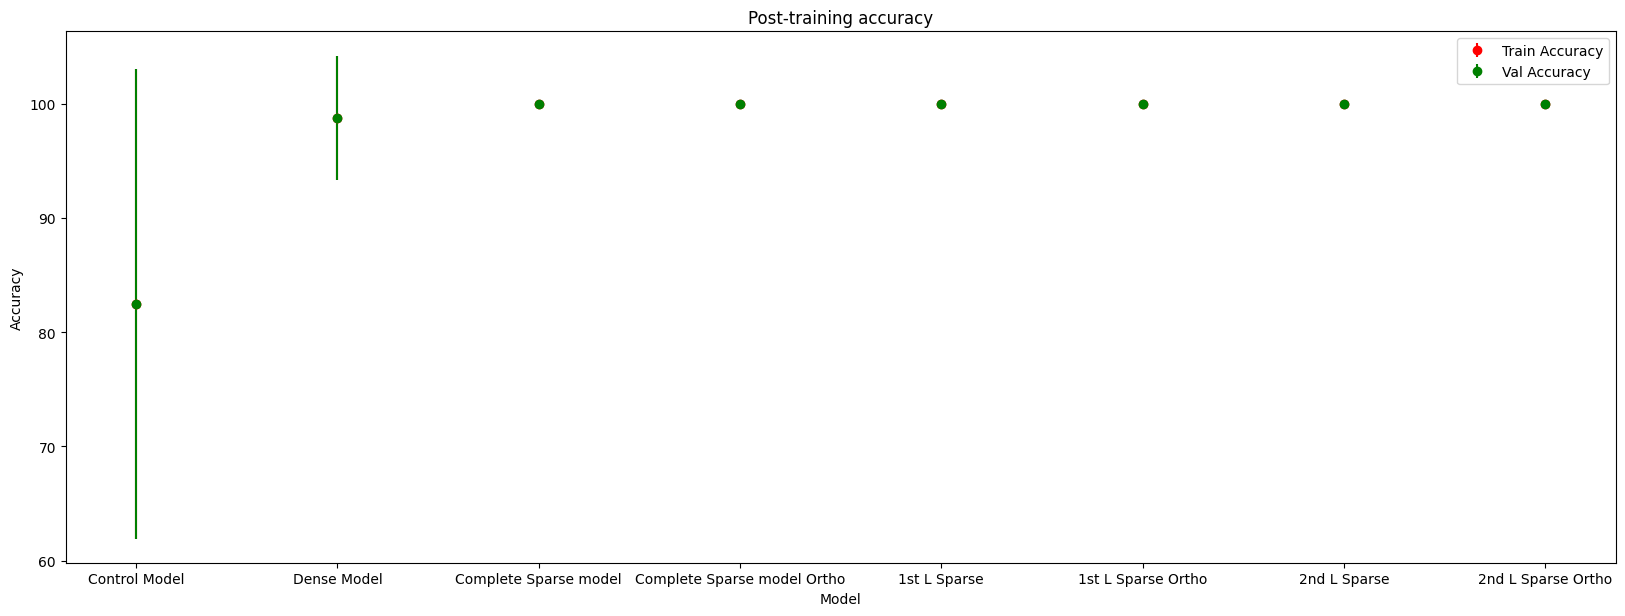

In [78]:
combined_charts.plot_training_data_for(no_std = True,
                                    #   models = control_models + dense_models 
                                       ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.ACC, 
    no_std = True,
    # models = control_models + dense_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=4,
    # models = control_models + dense_models 
    ).show()

In [161]:
# Experiment with different sparse values and same allowed percentages
layers = 3
model_params_base = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10)}
model_types_different_sparse = {}

def get_model_params(allow_percent, model_params):
    model_params_copy = model_params.copy()
    for layer in model_params:
        model_params_copy[layer] = (
            model_params[layer][0],
            max(1, int(allow_percent * model_params[layer][0]))
        )
    return model_params_copy

allowed_percentages = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

model_types_width_percent_allowed = {}
for allowed_percentage in allowed_percentages:
    model_types_width_percent_allowed[str(allowed_percentage)] = get_model_params(allowed_percentage, model_params_base)

model_types_width_percent_allowed

{'0.05': {'l1': (200, 10), 'l2': (250, 12), 'l3': (200, 10)},
 '0.075': {'l1': (200, 15), 'l2': (250, 18), 'l3': (200, 15)},
 '0.1': {'l1': (200, 20), 'l2': (250, 25), 'l3': (200, 20)},
 '0.15': {'l1': (200, 30), 'l2': (250, 37), 'l3': (200, 30)},
 '0.2': {'l1': (200, 40), 'l2': (250, 50), 'l3': (200, 40)},
 '0.25': {'l1': (200, 50), 'l2': (250, 62), 'l3': (200, 50)},
 '0.3': {'l1': (200, 60), 'l2': (250, 75), 'l3': (200, 60)},
 '0.35': {'l1': (200, 70), 'l2': (250, 87), 'l3': (200, 70)},
 '0.4': {'l1': (200, 80), 'l2': (250, 100), 'l3': (200, 80)}}

In [162]:
chartUtils = {}
for modelName in model_types_width_percent_allowed:
    chartUtils[modelName] = experiment.perform_one_experiment(
        models = {
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Sparse Ortho " + modelName: modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_percent_allowed[modelName]
        )

In [163]:
model_keys = list(chartUtils.keys())
combined_charts = chartUtils[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils[key])

ortho_models = [ i  for i in combined_charts.get_models() if "Ortho" in i]
sparse_models = [ i  for i in combined_charts.get_models() if "Ortho" not in i]
first_models = [ i  for i in combined_charts.get_models() if ("Ortho" in i and float(i[i.find("o ") + 2:]) in allowed_percentages[:5]) or ("Ortho" not in i and float(i[i.find("e ") + 2:]) in allowed_percentages[:5])]
last_models = [ i  for i in combined_charts.get_models() if not (("Ortho" in i and float(i[i.find("o ") + 2:]) in allowed_percentages[:5]) or ("Ortho" not in i and float(i[i.find("e ") + 2:]) in allowed_percentages[:5]))]

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/4163650847.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for().show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/4163650847.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(value_to_plot = TrainingCharts.ACC).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/4163650847.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_test_accu_for_models(width_alpha=3).show()


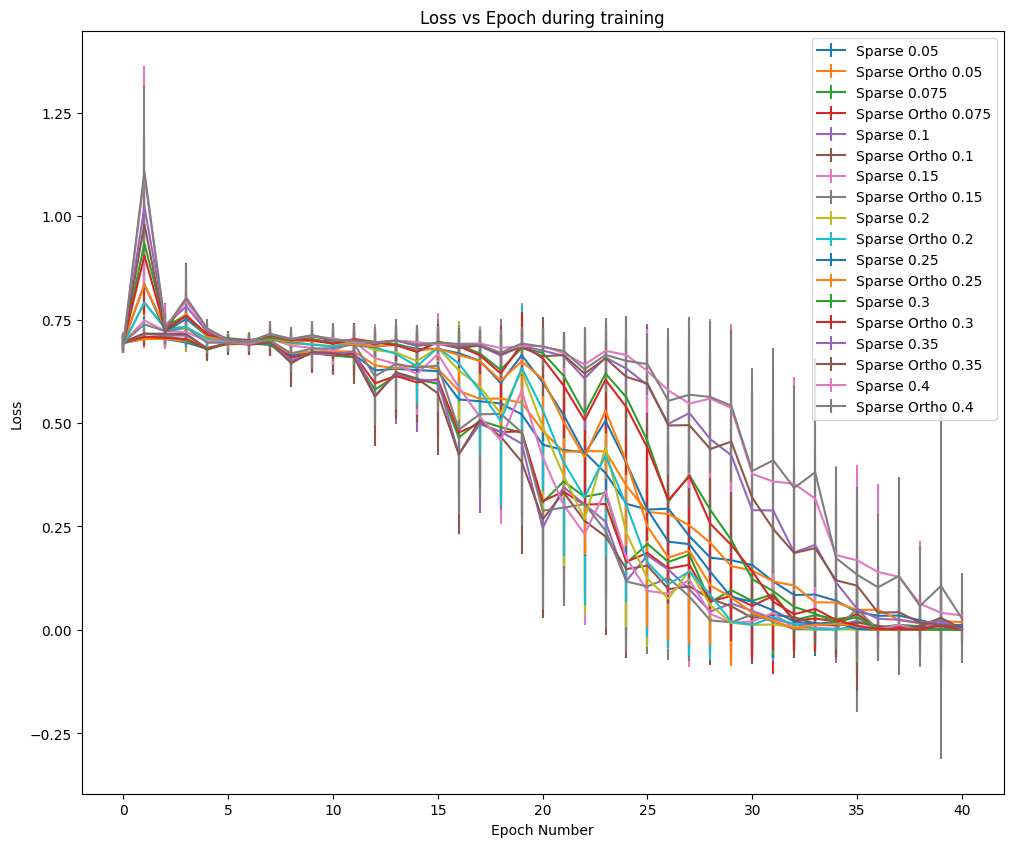

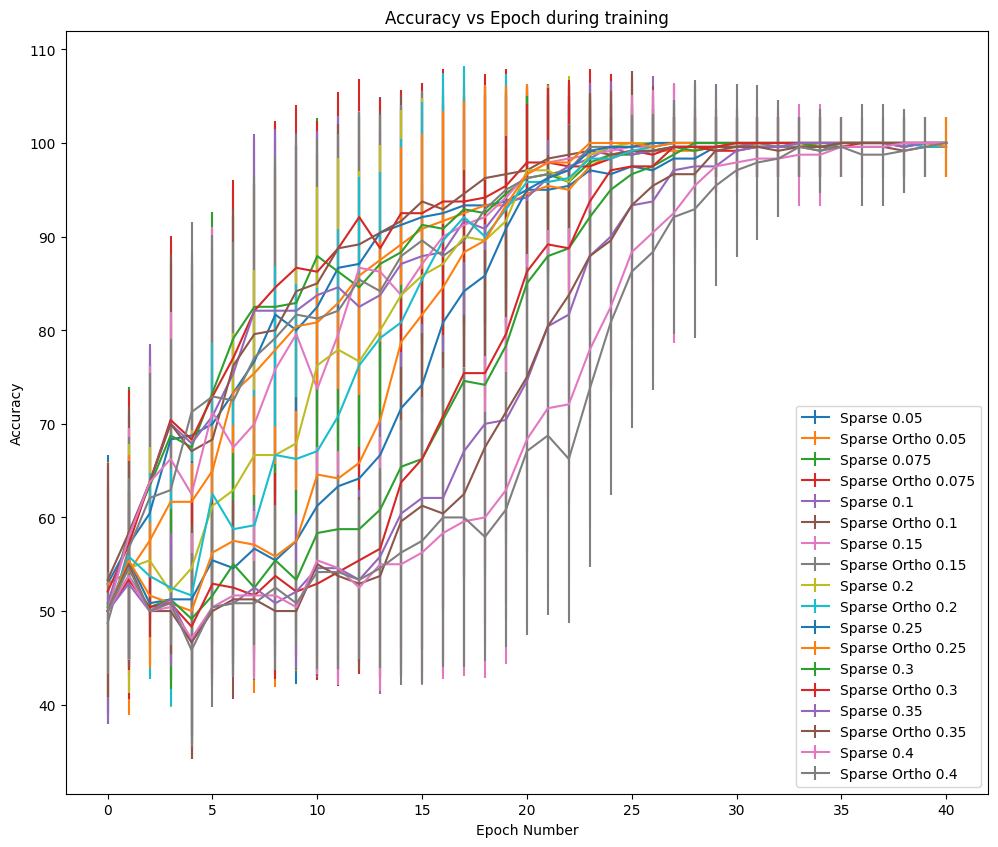

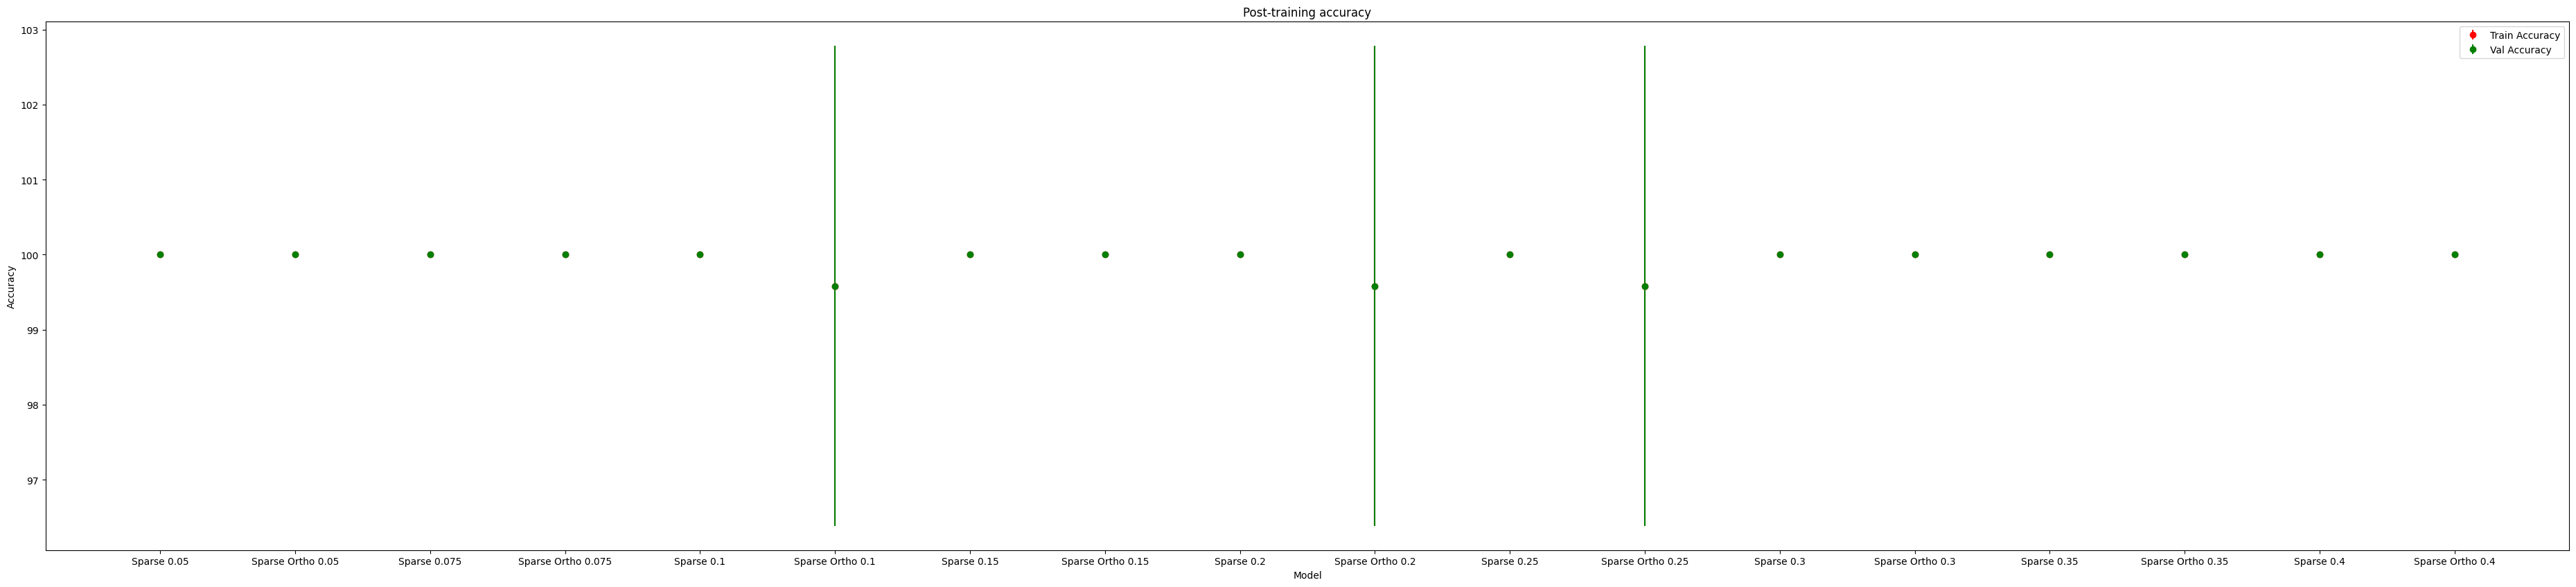

In [164]:
combined_charts.plot_training_data_for().show()
combined_charts.plot_training_data_for(value_to_plot = TrainingCharts.ACC).show()
combined_charts.plot_test_accu_for_models(width_alpha=3).show()

In [165]:
trainUtil.set_data_granularity(10)
chartUtils = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
        "Sparse Model": modelSetups._get_sparse_model,
        "Sparse Ortho Model": modelSetups._get_sparse_model
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = 3,  
    model_params = model_types["Complete Sparse model"]
)

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/1504342170.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  chartUtils.plot_training_data_for().show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/1504342170.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  chartUtils.plot_training_data_for(value_to_plot = TrainingCharts.ACC).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_80725/1504342170.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  chartUtils.plot_test_accu_for_models(width_alpha=3).show()


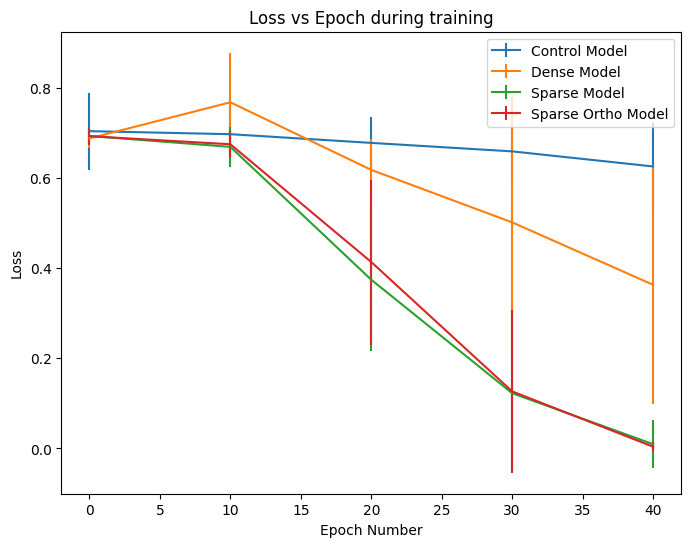

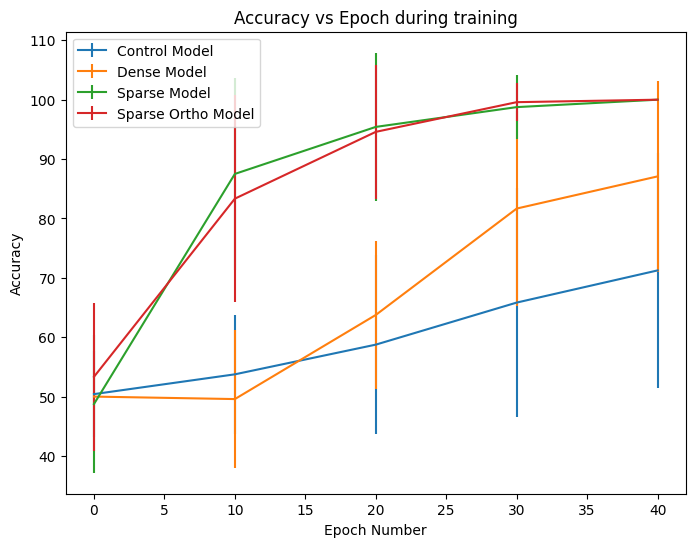

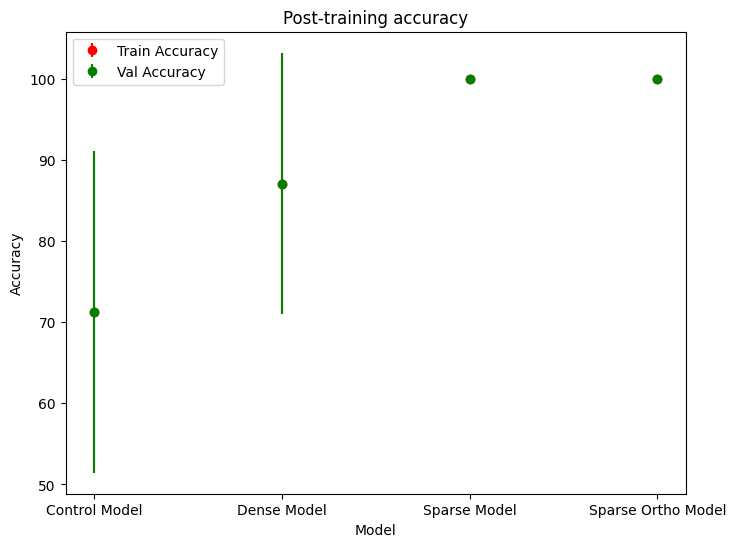

In [166]:
chartUtils.plot_training_data_for().show()
chartUtils.plot_training_data_for(value_to_plot = TrainingCharts.ACC).show()
chartUtils.plot_test_accu_for_models(width_alpha=3).show()

In [24]:
layers = 3
# Experiment with different widths and same allowed values
model_params_50 = {"l1": (50, 15), "l2": (70, 20), "l3": (50, 10)}
model_params_100 = {"l1": (100, 15), "l2": (150, 20), "l3": (100, 10)}
model_params_150 = {"l1": (150, 15), "l2": (170, 20), "l3": (150, 10)}
model_params_base = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10)}
model_params_250 = {"l1": (250, 15), "l2": (270, 20), "l3": (250, 10)}
model_params_300 = {"l1": (300, 15), "l2": (350, 20), "l3": (300, 10)}
model_params_350 = {"l1": (350, 15), "l2": (370, 20), "l3": (350, 10)}
model_params_400 = {"l1": (400, 15), "l2": (450, 20), "l3": (400, 10)}
# model_params_1000 = {"l1": (1000, 15), "l2": (1050, 20), "l3": (1000, 10)}

model_types_width_same_allowed = {"50": model_params_50,
               "100": model_params_100,
               "150": model_params_150,
               "base(200)": model_params_base,
               "250": model_params_250,
               "300": model_params_300,
               "350": model_params_350,
               "400": model_params_400,
            #    "1000": model_params_1000
}

# Experiment with different widths and same allowed percentages
def get_model_params(allow_percent, model_params):
    model_params_copy = model_params.copy()
    for layer in model_params:
        model_params_copy[layer] = (
            model_params[layer][0],
            max(1, int(allow_percent[layer] * model_params[layer][0]))
        )
    return model_params_copy

allowed_percentage = {
    "l1": 0.075,
    "l2": 0.08,
    "l3": 0.05
}

model_types_width_percent_allowed = {}
for modelName in model_types_width_same_allowed:
    model_types_width_percent_allowed[modelName] = get_model_params(allowed_percentage, model_types_width_same_allowed[modelName])

model_types_width_percent_allowed

{'50': {'l1': (50, 3), 'l2': (70, 5), 'l3': (50, 2)},
 '100': {'l1': (100, 7), 'l2': (150, 12), 'l3': (100, 5)},
 '150': {'l1': (150, 11), 'l2': (170, 13), 'l3': (150, 7)},
 'base(200)': {'l1': (200, 15), 'l2': (250, 20), 'l3': (200, 10)},
 '250': {'l1': (250, 18), 'l2': (270, 21), 'l3': (250, 12)},
 '300': {'l1': (300, 22), 'l2': (350, 28), 'l3': (300, 15)},
 '350': {'l1': (350, 26), 'l2': (370, 29), 'l3': (350, 17)},
 '400': {'l1': (400, 30), 'l2': (450, 36), 'l3': (400, 20)}}

In [25]:
chartUtils = {}

for modelName in model_types_width_same_allowed:
    chartUtils[modelName] = experiment.perform_one_experiment(
        models = {
            "Control " + modelName: modelSetups._get_control_model,
            "Dense " + modelName: modelSetups._get_dense_model,
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Sparse " + modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_same_allowed[modelName],
        # n_epochs=100
        )

In [26]:
chartUtilsPercentageAllowed = {}

for modelName in model_types_width_percent_allowed:
    chartUtilsPercentageAllowed[modelName] = experiment.perform_one_experiment(
        models = {
            "Control " + modelName: modelSetups._get_control_model,
            "Dense " + modelName: modelSetups._get_dense_model,
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Sparse " + modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types_width_percent_allowed[modelName],
        # n_epochs = 100
        )

In [27]:
model_keys = list(chartUtils.keys())
combined_charts = chartUtils[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils[key])

ortho_models, sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

model_keys = list(chartUtilsPercentageAllowed.keys())
combined_charts_allowed_percent = chartUtilsPercentageAllowed[model_keys[0]]

for key in model_keys[1:]:
    combined_charts_allowed_percent = combined_charts_allowed_percent.combine_charts(chartUtilsPercentageAllowed[key])


ortho_models_allowed, sparse_models_allowed, control_models_allowed, dense_models_allowed = get_models_to_plot_from_combined(combined_charts_allowed_percent)
combined_charts_allowed_percent.set_colors_map()

In [28]:
largest_models = [ i  for i in combined_charts.get_models() if "1000" in i]

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2086149848.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2086149848.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2086149848.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


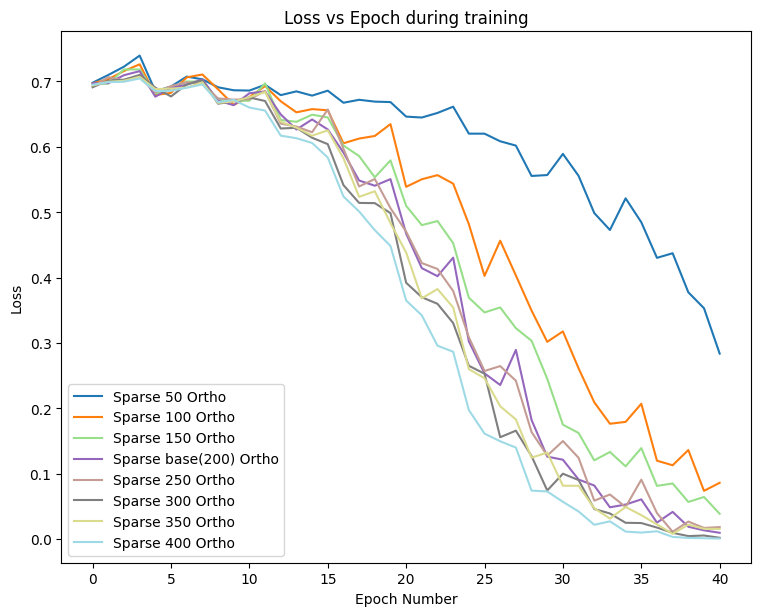

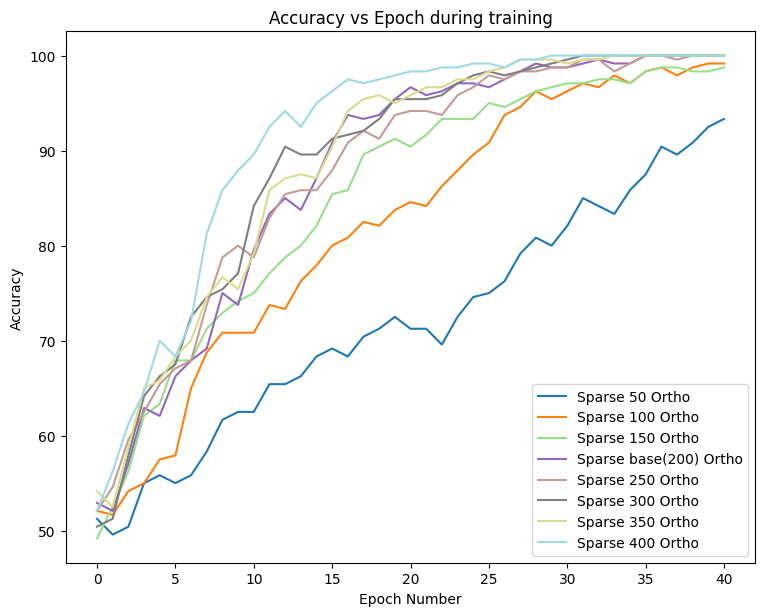

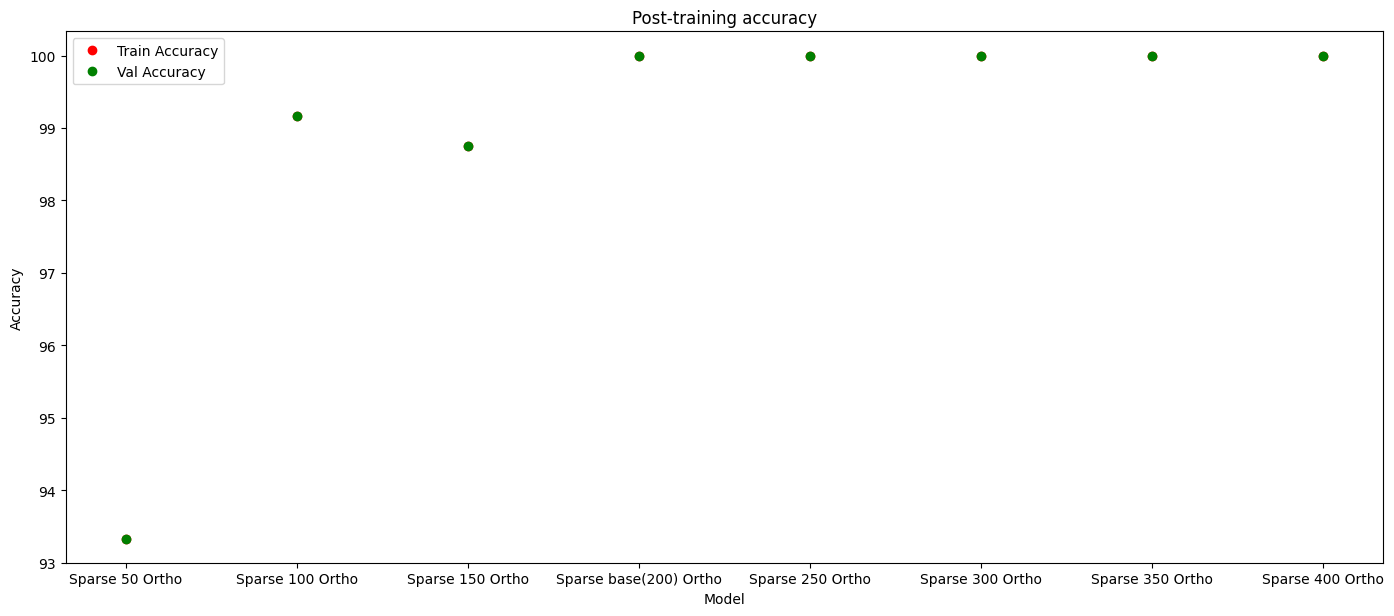

In [45]:
combined_charts.plot_training_data_for(no_std= True,
                                       set_unique_colors = True,
                                       models = ortho_models
                                       ).show()
combined_charts.plot_training_data_for(no_std= True, 
                                       value_to_plot = TrainingCharts.ACC, 
                                       set_unique_colors = True,
                                       models = ortho_models
                                       ).show()
combined_charts.plot_test_accu_for_models(width_alpha=3,
                                          no_std = True,
                                        models = ortho_models
                                          ).show()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/1235857370.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  set_unique_colors = True).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/1235857370.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  set_unique_colors = True).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/1235857370.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


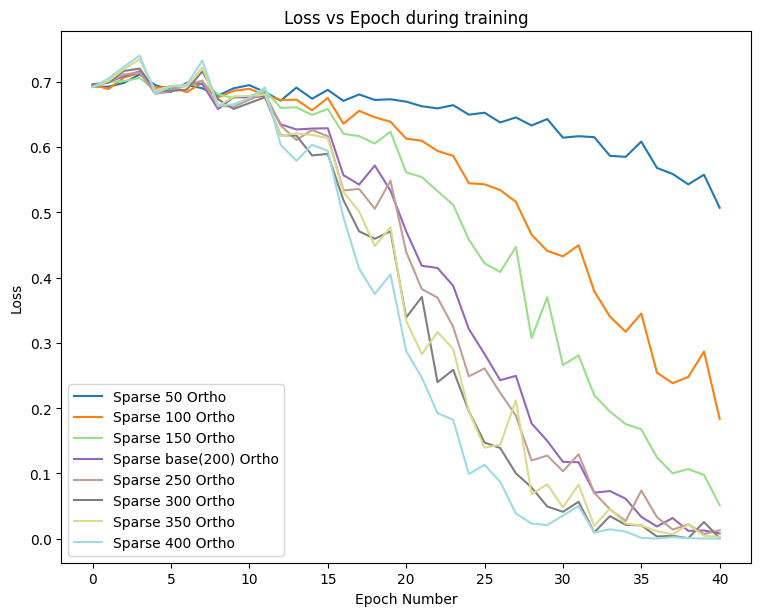

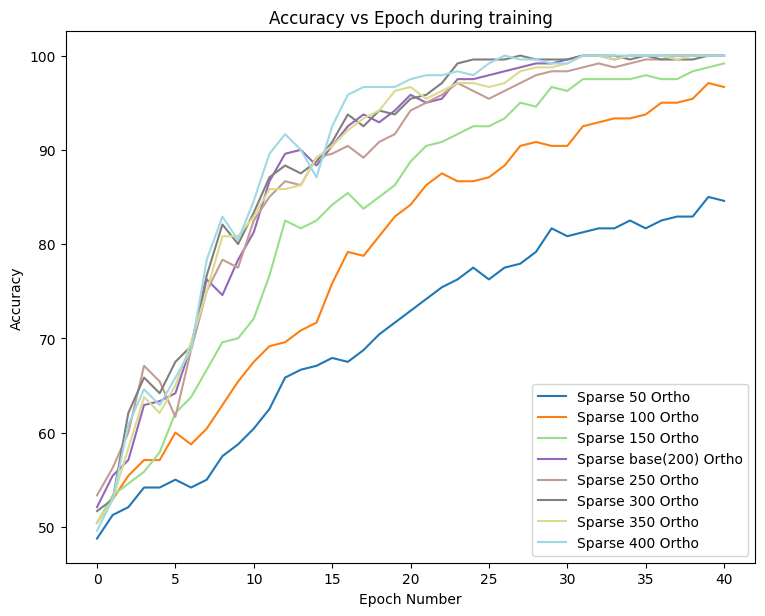

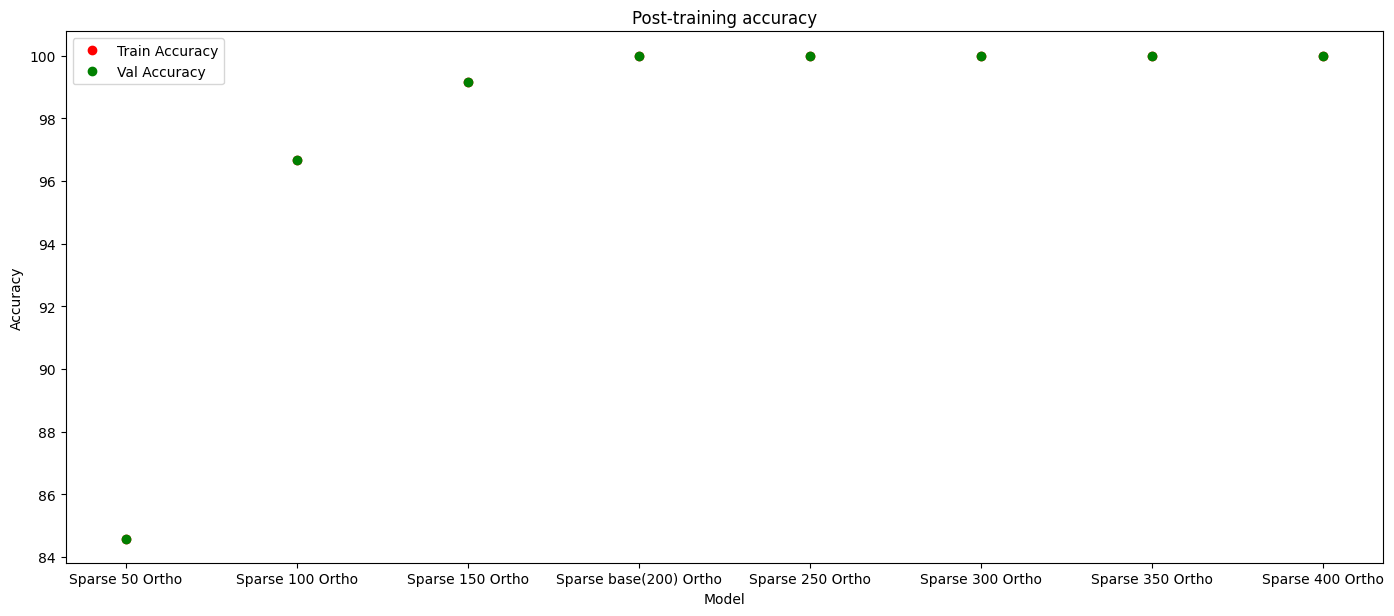

In [57]:
combined_charts_allowed_percent.plot_training_data_for(no_std= True, 
                                                       models = ortho_models   ,
                                                       set_unique_colors = True).show()
combined_charts_allowed_percent.plot_training_data_for(no_std= True,
                                                        models = ortho_models  ,
                                                        value_to_plot = TrainingCharts.ACC,
                                                        set_unique_colors = True).show()
combined_charts_allowed_percent.plot_test_accu_for_models(
                                                          width_alpha=3, 
                                                       models = ortho_models  ,
                                                          no_std = True
                                                          ).show()

In [58]:
layers = [1, 2, 3, 4, 5, 6]
# Experiment with different depths and same allowed values
model_params_1_layer = {"l1": (200, 15)}
model_params_2_layer = {"l1": (200, 15), "l2": (250, 20)}
model_params_base = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10)}
model_params_4_layer = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10), "l4": (200, 10)}
model_params_5_layer = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10), "l4": (200, 10), "l5": (250, 20)}
model_params_6_layer = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10), "l4": (200, 10), "l5": (250, 20), "l6": (200, 10)}

model_types_depth = {"1L": model_params_1_layer,
               "2L": model_params_2_layer,
               "base(3L)": model_params_base,
               "4L": model_params_4_layer,
               "5L": model_params_5_layer,
               "6L": model_params_6_layer
}

In [59]:
chartUtils = {}

for i, modelName in enumerate(model_types_depth):
    chartUtils[modelName] = experiment.perform_one_experiment(
        models = {
            "Control " + modelName: modelSetups._get_control_model,
            "Dense " + modelName: modelSetups._get_dense_model,
            "Sparse " + modelName: modelSetups._get_sparse_model,
            "Sparse " + modelName + " Ortho": modelSetups._get_sparse_model
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers[i], 
        model_params = model_types_depth[modelName],
        # n_epochs=100
        )

In [63]:
model_keys = list(chartUtils.keys())
combined_charts = chartUtils[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils[key])

ortho_models, sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2006475253.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2006475253.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_10826/2006475253.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


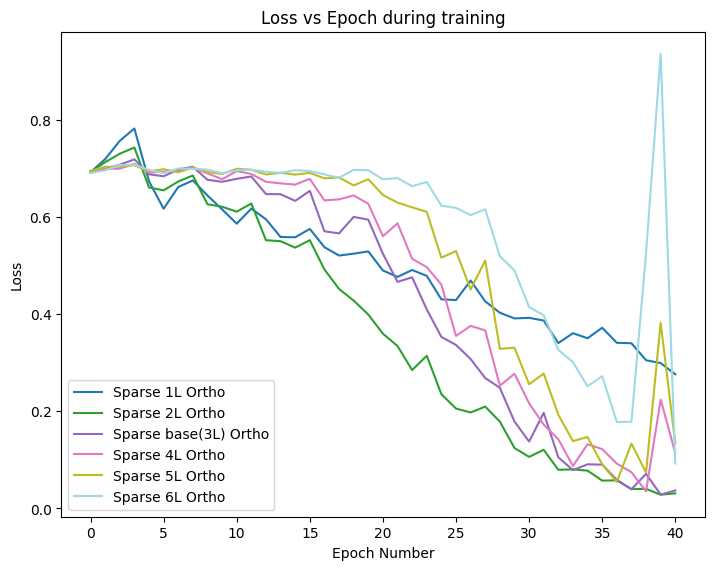

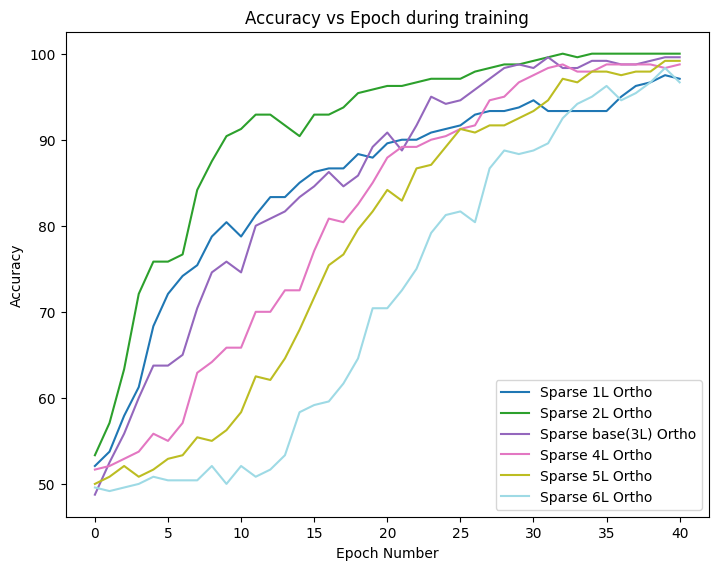

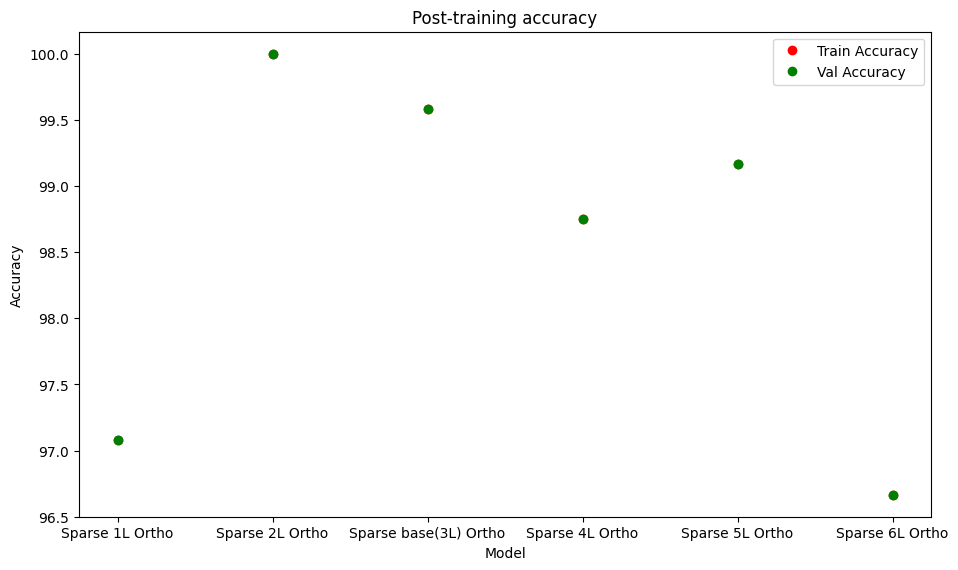

In [77]:
combined_charts.plot_training_data_for(no_std = True, 
                                       set_unique_colors = True,
                                       models = ortho_models
                                       ).show()
combined_charts.plot_training_data_for(no_std= True, 
                                       value_to_plot = TrainingCharts.ACC,
                                       set_unique_colors = True,
                                       models = ortho_models
                                       ).show()
combined_charts.plot_test_accu_for_models(width_alpha=3,
                                          no_std = True,
                                          models = ortho_models
                                          ).show()